# `qfit` Quick Start

## Background & your task

You are given a **superconducting circuit** composed of a fluxonium qubit and a resonator mode. They are capacitively coupled. The effective circuit is shown below:
<p align="center">
  <img width="300" src="resources/images/example_circuit.png">
</p>  

This circuit is described by the following **Hamiltonian**:
$$
H = H_{\rm res} + H_{\rm qubit} + H_{\rm int}
$$
with the resonator and qubit Hamiltonians and their interactions given by
\begin{align*}
H_{\rm res} &= E_{\rm osc} a^\dagger a \\
H_{\rm qubit} &= 4E_C n^2 - E_J \cos(\varphi+2\pi\Phi_{\rm ext}/\Phi_0) + \frac{1}{2}E_L\varphi^2 \\
H_{\rm int} &= g \frac{-i}{\sqrt{2}l_{\rm osc}} (a-a^\dagger) n
\end{align*}
where $a$ is the annihilation operator of the resonator, $n$ ($\varphi$) is the number (phase) operator of the qubit. $\Phi_{\rm ext}$ is the external flux, and $\Phi_0$ is the flux quantum.  Circuit parameters and their estimates (typically obtained from EM simulations and the Ambegaokar–Baratoff relation) are listed below:

| Parameter | Symbol | Rough Estimate |
| --- | --- | --- |
| Josephson Energy | $E_J$ | $3.0\textrm{ GHz}\times h$ |
| Charging Energy | $E_C$ | $0.9\textrm{ GHz}\times h$ |
| Inductive Energy | $E_L$ | $0.25\textrm{ GHz}\times h$ |
| Oscillator Length | $l_{\rm osc}$ | $1.0$ |
| Coupling Strength | $g$ | $0.15 \textrm{ GHz}\times h$ |

In addition, the resonator frequency $E_{\mathrm{osc}}$ is obtained by other means and is $6.035\textrm{ GHz}\times h$.

To determine the parameter described above, one can perform a **two-tone spectroscopy experiment**. It's summarized in the image below:
<figure align="center">
  <img width="700" src="resources/images/example_two_tone_setup.png">
</figure>  

In the experiment, two tones of RF drive are applied to the system - a tone with frequency $\omega$ to the qubit and a tone near frequency $E_{\rm osc} / h$ to the resonator. One then measure the transmission or reflection of the RF signal through the resonator. If the qubit drive pulse frequency $\omega$ happens to match a transition frequency of the qubit-resonator system, then the pulse may drive this transition. This may introduce a shift on the resonator frequency, which changes the amplitude and phase of the transmission/reflection signal. By performing such measurement for different $\omega$ and $\Phi_{\rm ext}$, one can obtain obtain the spectroscopy data.

Check out below for an example of such dataset:

Below is the information of the dataset and the shape of elements:
freq (2793,)
mags (81, 2793)
voltage (81,)


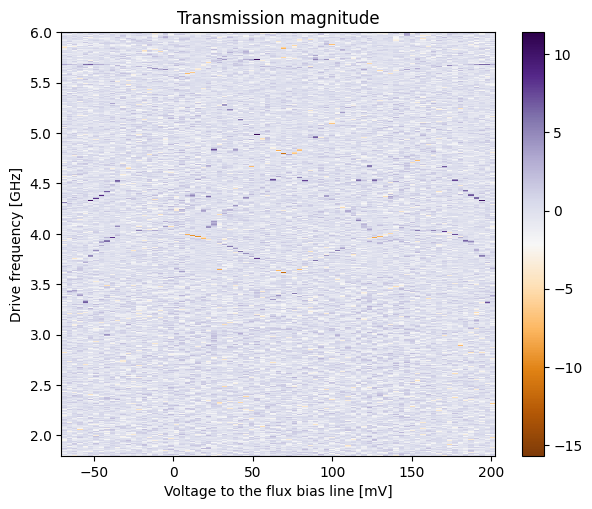

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset in the h5 file (you don't need to do this while using QFit)
print("Below is the information of the dataset and the shape of elements:")
dataset_path = "./example_dataset/joint_qubit_twotone.h5"
with h5py.File(dataset_path, "r") as file:
    # Print the information of the data
    def print_info(name, obj):
        print(name, obj.shape)
    file.visititems(print_info)

    # store the data in those variables
    dataset = np.array(file["mags"])
    omega, voltage = np.meshgrid(file["freq"], file["voltage"], indexing="ij")

# Plot the data
plt.figure(figsize=(7, 5.5))
plt.pcolormesh(voltage, omega, dataset.T, cmap="PuOr", rasterized=True)
plt.colorbar()
plt.xlabel("Voltage to the flux bias line [mV]")
plt.ylabel("Drive frequency [GHz]")
plt.title("Transmission magnitude")
plt.show()

In the dataset, the peaks (appears as dark purple/dark yellow spots) represent resonances between the $\omega$ and the transition frequencies. **Your task is to fit the dataset and extract the parameters.** - This is where `qfit` comes in. 

## Step 0: Build a numerical model and run `qfit`

We have helped you to create a numerical model of the quantum system using `scqubits.HilbertSpace`. To see the usage of `scqubits` in detail, please refer to the [scqubits documentation](https://scqubits.readthedocs.io/en/latest/).

In [2]:
import scqubits as scq

fluxonium = scq.Fluxonium(
    EJ = 3.0,
    EC = 0.9,
    EL = 0.25,
    flux = 0.5,
    cutoff = 100,
    truncated_dim = 5,
    id_str = "Fluxonium"
)
resonator = scq.Oscillator(
    E_osc = 5.6,
    l_osc = 1.0,
    truncated_dim = 4,
    id_str = "Resonator"
)

hilbert_space = scq.HilbertSpace([fluxonium, resonator])

hilbert_space.add_interaction(
    g = 1,
    op1 = fluxonium.n_operator,
    op2 = resonator.n_operator,
    add_hc = False,
    id_str = "res-qubit"
)

 /opt/miniconda3/envs/qfit-env/lib/python3.11/site-packages/scipy/linalg/_matfuncs.py: 326RuntimeWarning: overflow encountered in matmul
 /opt/miniconda3/envs/qfit-env/lib/python3.11/site-packages/scipy/linalg/_matfuncs.py: 326RuntimeWarning: invalid value encountered in matmul
 /opt/miniconda3/envs/qfit-env/lib/python3.11/site-packages/scipy/linalg/_matfuncs.py: 326RuntimeWarning: divide by zero encountered in matmul
 /opt/miniconda3/envs/qfit-env/lib/python3.11/site-packages/scipy/linalg/_matfuncs.py: 358RuntimeWarning: overflow encountered in matmul
 /opt/miniconda3/envs/qfit-env/lib/python3.11/site-packages/scipy/linalg/_matfuncs.py: 358RuntimeWarning: invalid value encountered in matmul
 /opt/miniconda3/envs/qfit-env/lib/python3.11/site-packages/scipy/linalg/_matfuncs.py: 358RuntimeWarning: divide by zero encountered in matmul
 /opt/miniconda3/envs/qfit-env/lib/python3.11/site-packages/scqubits/utils/spectrum_utils.py: 199RuntimeWarning: overflow encountered in matmul
 /opt/minico

#### Provide experimental dataset and launch `qfit`

Open the app using `Fit(<HilbertSpace>, <dataset file path>)`. An app (the graphical user interface, GUI) will pop up and we'll guide you through the GUI in the next few subsections. You may treat the following sections as a documentation and refer to it if necessary. Also you may click on the ? buttons for help.

In [3]:
from qfit import Fit

In [4]:
dataset_path = "/Users/h2/Documents/QDWS2025/Day2/scqubits_JensKoch/qfit/example_dataset/joint_qubit_twotone.h5"
fit = Fit(hilbert_space, dataset_path)

qt.qpa.fonts: Populating font family aliases took 106 ms. Replace uses of missing font family "Roboto Medium" with one that exists to avoid this cost. 


## Save, load and export
You may save / load the fitting session by clicking the <img width="20" src="resources/images/example_menu.png"> button on the top left. The session will be saved as a `.qfit` file.

You can also open a new window to load the previous session.

In [5]:
# this is an example file we already prepared for you
# If you didn't close the previous window, you'll get another one
qfit_file_path = "/Users/h2/Documents/QDWS2025/Day2/scqubits_JensKoch/qfit/example_qfit_file/QFit_Quick_Start.qfit"
fit = Fit.open(qfit_file_path)

Exporting the `HilbertSpace` instance

In [6]:
# To get the HilbertSpace object and continue working on it
fit_hilbertspace = fit.export_hilbertspace(deepcopy=True, from_fit=True)
fit_hilbertspace

HilbertSpace(**{'subsystem_list': [Fluxonium(**{'EJ': np.float64(3.371617115882368), 'EC': np.float64(1.035134259258186), 'EL': np.float64(0.20149169023352737), 'flux': np.float64(0.9733928571428574), 'cutoff': 100, 'truncated_dim': 5, 'id_str': 'Fluxonium', 'evals_method': None, 'evals_method_options': None, 'esys_method': None, 'esys_method_options': None}), Oscillator(**{'E_osc': np.float64(5.608095218795535), 'l_osc': 1.0, 'truncated_dim': 4, 'id_str': 'Resonator'})], 'interaction_list': [InteractionTerm(**{'g_strength': np.float64(1.0043077810113954), 'operator_list': [(1, <bound method Oscillator.n_operator of Oscillator(**{'E_osc': np.float64(5.608095218795535), 'l_osc': 1.0, 'truncated_dim': 4, 'id_str': 'Resonator'})>), (0, <bound method Fluxonium.n_operator of Fluxonium(**{'EJ': np.float64(3.371617115882368), 'EC': np.float64(1.035134259258186), 'EL': np.float64(0.20149169023352737), 'flux': np.float64(0.9733928571428574), 'cutoff': 100, 'truncated_dim': 5, 'id_str': 'Fluxoni

## Import multiple datasets

`QFit` also support working with multiple datasets simultaneously

In [9]:
dataset_paths = [
    "/Users/h2/Documents/QDWS2025/Day2/scqubits_JensKoch/qfit/example_dataset/qubit_twotone_1.h5",
    "/Users/h2/Documents/QDWS2025/Day2/scqubits_JensKoch/qfit/example_dataset/qubit_twotone_2.h5",
    "/Users/h2/Documents/QDWS2025/Day2/scqubits_JensKoch/qfit/example_dataset/qubit_twotone_3.h5",
    "/Users/h2/Documents/QDWS2025/Day2/scqubits_JensKoch/qfit/example_dataset/qubit_twotone_4.h5",
]
fit_multiple_datasets = Fit(hilbert_space, dataset_paths)

After the import stage, the method `create_standalone_canvas` allows us to plot multiple selected datasets in a single standalone canvas. Notice that any updates on the visual settings for each individual dataset will not be updated on the standalone canvas; one need to create a new standalone canvas to update.

In [10]:
fit_multiple_datasets.create_standalone_canvas(
    selected_dataset_names=[
        "qubit_twotone_1.h5",
        "qubit_twotone_2.h5",
        "qubit_twotone_3.h5",
        "qubit_twotone_4.h5",
    ],
    points_added=10,
)

AssertionError: Calibration function not found

Traceback (most recent call last):
  File "/opt/miniconda3/envs/qfit-env/lib/python3.11/site-packages/qfit/controllers/io_ctrl.py", line 478, in closeByMainWindow
    status = self.closeAppAfterSaving()
             ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/qfit-env/lib/python3.11/site-packages/qfit/controllers/io_ctrl.py", line 293, in closeAppAfterSaving
    assert registryDictFromFile is not None, "File not found"
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: File not found
